Odpowiedź ma być skrypt pythona i odpalamy go z terminala za pomocą np. argparse

python classify.py test.csv

Na wejściu jest plik test.csv, tam mamy dopisać kolumnę nową z nazwą "RESULT" i nadpisać plik csv

* team: T – terrorists, CT – counter-terrorists;
* (detonation raw x, detonation raw y , detonation raw z ): grenade detonation raw coordinates;
* (throw from raw x, throw from raw y, throw from raw z ): raw coordinates of the player when the grenade is being thrown;
* throw tick : the exact tick (unit of game time, 128 ticks per second, counted from the beginning of the game), when the grenade is being thrown;
* detonation tick : the exact tick, when the grenade is being detonated;
* TYPE : type of the grenade (smoke, flashbang, molotov );
* map name: map on which the match was played (de inferno, de mirage);

In [1]:
import pandas as pd
import numpy as np

#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#PCA
from sklearn.decomposition import PCA

#Machine Learning models
from sklearn.ensemble import RandomForestClassifier


In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        543 non-null    int64  
 1   demo_id           543 non-null    int64  
 2   demo_round_id     543 non-null    int64  
 3   round_start_tick  543 non-null    int64  
 4   weapon_fire_id    543 non-null    int64  
 5   team              543 non-null    object 
 6   detonation_raw_x  543 non-null    float64
 7   detonation_raw_y  543 non-null    float64
 8   detonation_raw_z  543 non-null    float64
 9   throw_from_raw_x  543 non-null    float64
 10  throw_from_raw_y  543 non-null    float64
 11  throw_from_raw_z  543 non-null    float64
 12  throw_tick        543 non-null    int64  
 13  detonation_tick   543 non-null    float64
 14  TYPE              543 non-null    object 
 15  map_name          543 non-null    object 
 16  LABEL             543 non-null    bool   
dt

In [14]:
train.isna().sum()

Unnamed: 0          0
demo_id             0
demo_round_id       0
round_start_tick    0
weapon_fire_id      0
team                0
detonation_raw_x    0
detonation_raw_y    0
detonation_raw_z    0
throw_from_raw_x    0
throw_from_raw_y    0
throw_from_raw_z    0
throw_tick          0
detonation_tick     0
TYPE                0
map_name            0
LABEL               0
dtype: int64

Wiem, że mam do czynienia z danymi niezbalansowanymi  
* Muszę przejrzeć istotność danych cech  
* Muszę zrobić wykres z mapami csgo, napisanie funkcji, która przyjmuje na wejściu dany wiersz z train_data i wyrzuca obrazek gdzie jest oznaczone miejsce wyrzutu i opadniecia granatu
* Zamianienie informacji o tick na sekundy, dodanie moze nowej zmiennej, która będzie mówiła o tym ile leciał dany granat 
* wizualizacja, wizualizacja i jeszcze raz wizualizacja
* później spróbować zrobić PCA i zwizualizować dane, czy są liniowo, czy nieliniowo rozdzielne
* popatrzeć na modele, które mogę użyć
* Zaaplikować modele, następnie dodać skalowanie (zobaczyć, czy coś sie zmieni)
* Sprawdzić zespoły modelów 
* Dodać dostrajanie hiperparametrów 
* obczaić zapisywanie modelu (ang. serialized)
* obczaić jak odpalić to tak jak wymagają argparse

In [16]:
def scale_point_x(x,startX,endX,res_X=1024):
    sizeX=endX-startX
    if startX < 0:
        x += startX *(-1.0)
    else:
        x += startX
    x_out = float((x / abs(sizeX)) * res_X)
    return x_out

def scale_point_y(y,startY,endY,res_Y=1024):
    sizeY=endY-startY
    if startY < 0:
        y += startY *(-1.0)
    else:
        y += startY
    y_out = float((y / abs(sizeY)) * res_Y)
    return res_Y-y_out

In [17]:
mirage = train[(train['map_name'] == 'de_mirage')]

In [18]:

def add_attributes(df,startX,endX,startY,endY):
    df['detonation_x'] = df['detonation_raw_x'].apply(lambda x: scale_point_x(x,startX=startX, endX=endX))
    df['detonation_y'] = df['detonation_raw_y'].apply(lambda x: scale_point_y(x,startY=startY, endY=endY))
    df['throw_x'] = df['throw_from_raw_x'].apply(lambda x: scale_point_x(x,startX=startX, endX=endX))
    df['throw_y'] = df['throw_from_raw_y'].apply(lambda x: scale_point_y(x,startY=startY, endY=endY))
    return df

In [19]:
mirage = add_attributes(mirage,-3217,1912,-3401,1682)

In [20]:
def nades_on_map(df,map):
    map_name = 'maps/' + map + '.png'
    im = plt.imread(map_name)
    plt.figure(figsize=(22,11))
    plt.subplot(1,2,1)
    t = plt.imshow(im)
    sns.scatterplot(x = df[df['LABEL'] == True]['detonation_x'], y = df[df['LABEL'] == True]['detonation_y'], hue = df[df['LABEL'] == True]['TYPE'], marker = "s", s = 50)
    ax = sns.scatterplot(x = df[df['LABEL'] == True]['throw_x'],y = df[df['LABEL'] == True]['throw_y'], hue = df[df['LABEL'] == True]['TYPE'], marker="^" , s = 50)
    handles, labels = ax.get_legend_handles_labels()
    detonation_patch = mlines.Line2D([], [], color = 'grey', marker='s', linestyle='None')
    throw_patch = mlines.Line2D([], [], color = 'grey', marker='^', linestyle='None')
    handles.extend([detonation_patch,throw_patch])
    labels.extend(['Detonation','Throw'])
    plt.legend(handles[3:], labels[3:])
    plt.title('Correct throw')


    plt.subplot(1,2,2)
    t = plt.imshow(im)
    sns.scatterplot(x = df[df['LABEL'] == False]['detonation_x'], y = df[df['LABEL'] == False]['detonation_y'], hue = df[df['LABEL'] == False]['TYPE'], marker = "s", s = 50)
    ax = sns.scatterplot(x = df[df['LABEL'] == False]['throw_x'],y = df[df['LABEL'] == False]['throw_y'], hue = df[df['LABEL'] == False]['TYPE'], marker="^" , s = 50)
    handles, labels = ax.get_legend_handles_labels()
    detonation_patch = mlines.Line2D([], [], color = 'grey', marker='s', linestyle='None')
    throw_patch = mlines.Line2D([], [], color = 'grey', marker='^', linestyle='None')
    handles.extend([detonation_patch,throw_patch])
    labels.extend(['Detonation','Throw'])
    plt.legend(handles[3:], labels[3:])
    plt.title('Incorrect throw')
    plt.show()


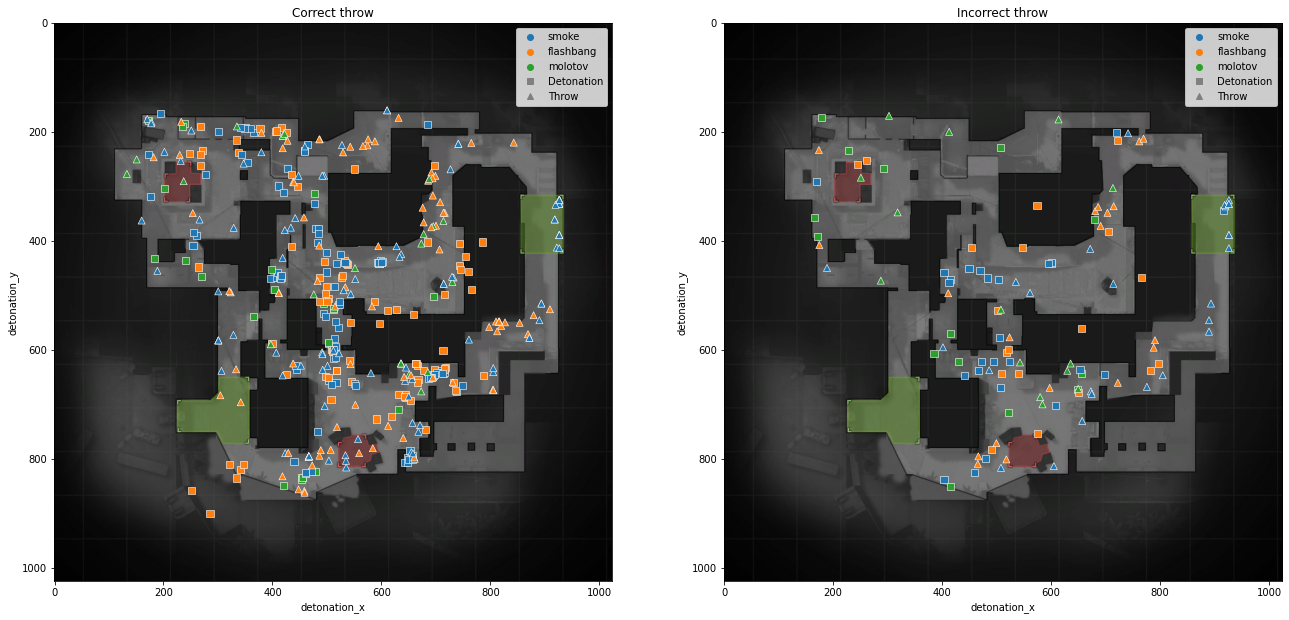

In [21]:
nades_on_map(mirage,'de_mirage')
#plt.savefig('./plots/granades_on_mirage.png')

In [22]:
inferno = train[(train['map_name'] == 'de_inferno')]

In [23]:
inferno = add_attributes(inferno,-1960,2797,-1062,3800)

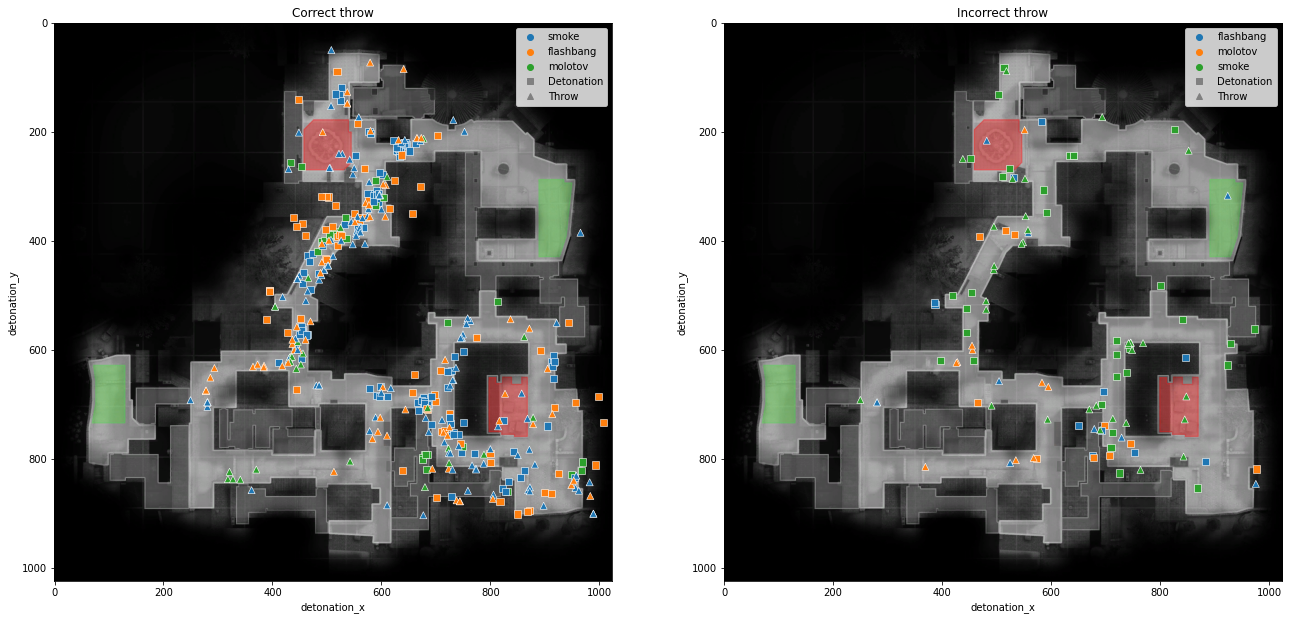

In [24]:
nades_on_map(inferno,'de_inferno')
#plt.savefig('./plots/granades_on_inferno.png')

In [27]:
#funtion to show one nade throwed
def draw_nade(row):
    map = row['map_name']
    label = row['LABEL']
    nade_type = row['TYPE'] 
    
    if map == 'de_inferno':
        map_name = 'maps/' + map + '.png'
        startX,endX,startY,endY = -1960,2797,-1062,3800

    elif map == 'de_mirage':
        map_name = 'maps/' + map + '.png'
        startX,endX,startY,endY = -3217,1912,-3401,1682

    else :
        print('Map incorrect')
    
    detonation_x = scale_point_x(row['detonation_raw_x'],startX = startX, endX = endX)
    detonation_y = scale_point_y(row['detonation_raw_y'],startY=startY, endY=endY)
    throw_x = scale_point_x(row['throw_from_raw_x'],startX=startX, endX=endX)
    throw_y = scale_point_y(row['throw_from_raw_y'],startY=startY, endY=endY)

    plt.figure(figsize=(11,11))
    im = plt.imread(map_name)
    t = plt.imshow(im)
    sns.scatterplot(x = [detonation_x], y = [detonation_y], color = 'blue', marker = "s", s = 50)
    ax = sns.scatterplot(x = [throw_x],y = [throw_y], color = 'orange', marker="^" , s = 50)
    detonation_patch = mlines.Line2D([], [], color = 'blue', marker='s', linestyle='None')
    throw_patch = mlines.Line2D([], [], color = 'orange', marker='^', linestyle='None')
    handles = [detonation_patch,throw_patch]
    labels = ['Detonation','Throw']
    ax.text(50, 100, 'Map:{},\nGranade:{},\nThrown correctly:{}'.format(map,nade_type,label),
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
    plt.legend(handles, labels)
    plt.show()


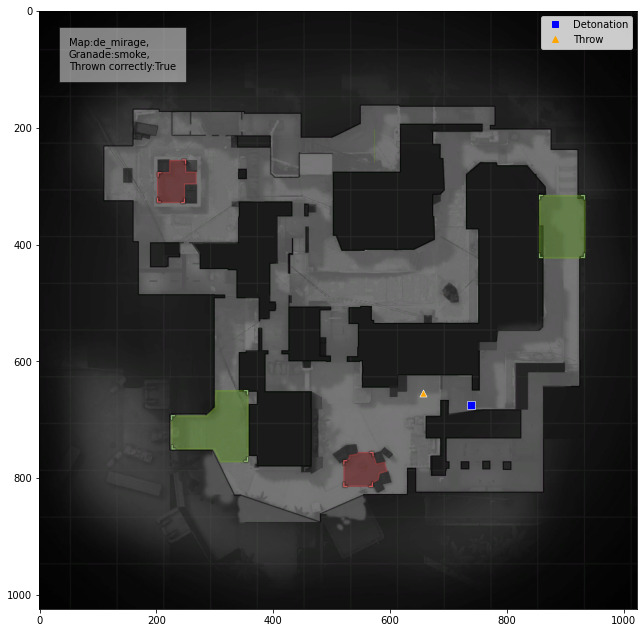

In [28]:
draw_nade(train.iloc[2])

## More visualization

In [36]:
def plot_count(feature, data):
    plt.figure(figsize = (7,7))
    ax = sns.countplot(x = feature, data = data,  palette='colorblind')
    height = sum([p.get_height() for p in ax.patches])
    for p in ax.patches:
            ax.annotate(f'{100*p.get_height()/height:.2f} %', (p.get_x()+0.3, p.get_height()+10),animated=True)
    plot_name = 'plots/{}_plot.png'.format(feature)
    plt.savefig(plot_name)
    plt.show()

In [44]:
def plot_count_vs_variable(feature, data, vs):
    plt.figure(figsize = (7,7))
    ax = sns.countplot(x = feature, data = data, hue = vs, palette='colorblind')
    height = sum([p.get_height() for p in ax.patches])
    for p in ax.patches:
            ax.annotate(f'{100*p.get_height()/height:.2f} %', (p.get_x()+0.3, p.get_height()+10),animated=True)
    plot_name = 'plots/{}_plot.png'.format(feature)
    plt.savefig(plot_name)
    plt.show()

In [37]:
def histogram(feature, data):    
    plt.show()

In [31]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        543 non-null    int64  
 1   demo_id           543 non-null    int64  
 2   demo_round_id     543 non-null    int64  
 3   round_start_tick  543 non-null    int64  
 4   weapon_fire_id    543 non-null    int64  
 5   team              543 non-null    object 
 6   detonation_raw_x  543 non-null    float64
 7   detonation_raw_y  543 non-null    float64
 8   detonation_raw_z  543 non-null    float64
 9   throw_from_raw_x  543 non-null    float64
 10  throw_from_raw_y  543 non-null    float64
 11  throw_from_raw_z  543 non-null    float64
 12  throw_tick        543 non-null    int64  
 13  detonation_tick   543 non-null    float64
 14  TYPE              543 non-null    object 
 15  map_name          543 non-null    object 
 16  LABEL             543 non-null    bool   
dt

### Team

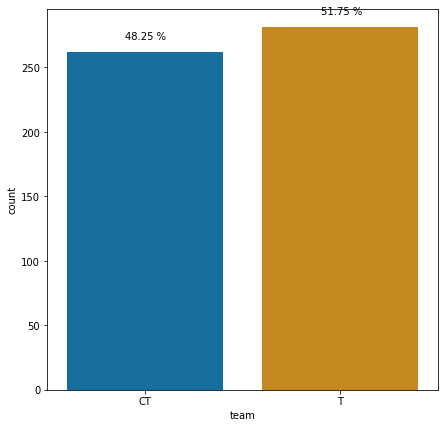

In [42]:
plot_count('team' ,train)

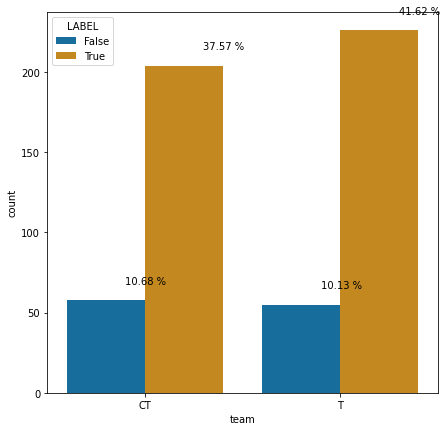

In [45]:
plot_count_vs_variable('team',train,'LABEL')

### Grenade type

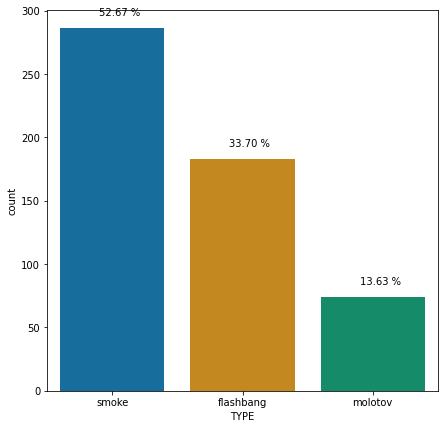

In [46]:
plot_count('TYPE' ,train)

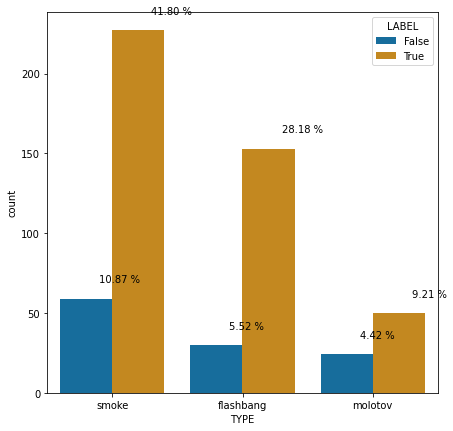

In [47]:
plot_count_vs_variable('TYPE',train,'LABEL')

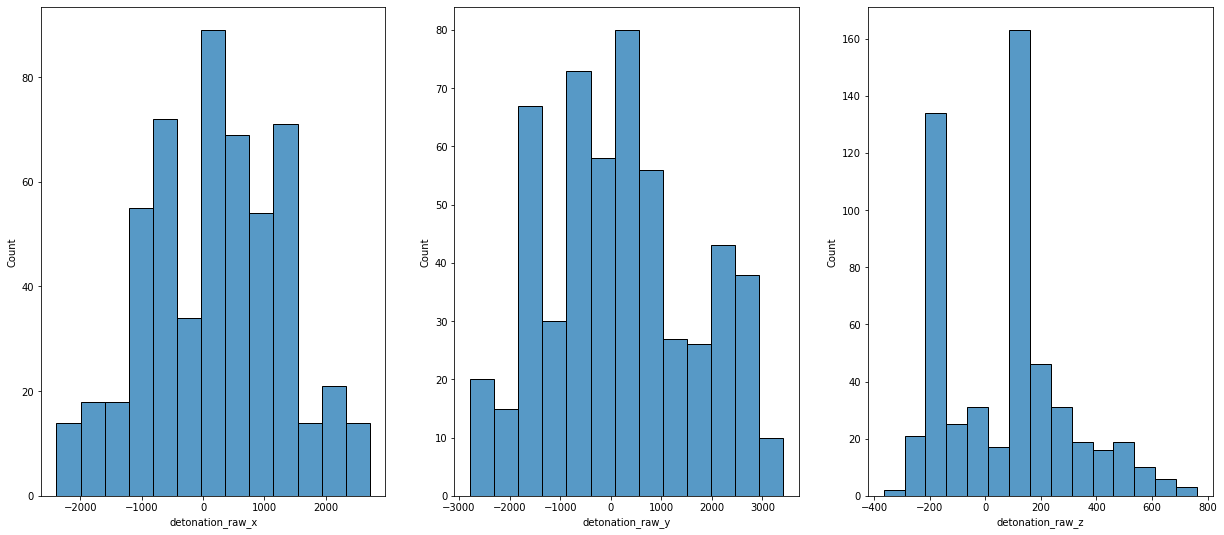

In [60]:
plt.figure(figsize= (21,9))
plt.subplot(1,3,1)
sns.histplot(x = train['detonation_raw_x'])
plt.subplot(1,3,2)
sns.histplot(x = train['detonation_raw_y'])
plt.subplot(1,3,3)
sns.histplot(x = train['detonation_raw_z'])
plt.show()


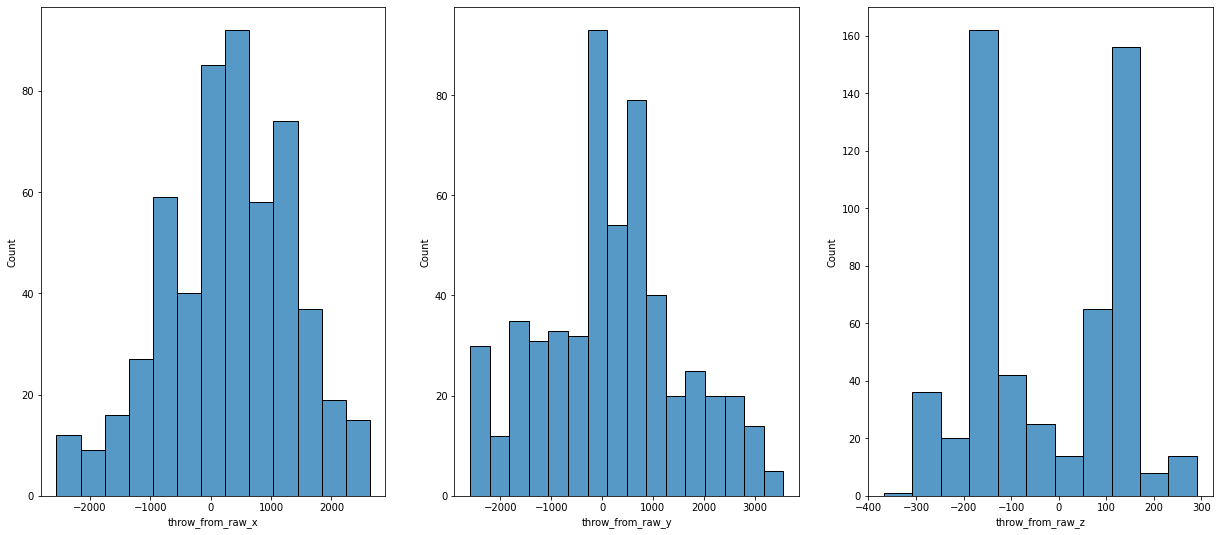

In [61]:
plt.figure(figsize= (21,9))
plt.subplot(1,3,1)
sns.histplot(x = train['throw_from_raw_x'])
plt.subplot(1,3,2)
sns.histplot(x = train['throw_from_raw_y'])
plt.subplot(1,3,3)
sns.histplot(x = train['throw_from_raw_z'])
plt.show()

<AxesSubplot:>

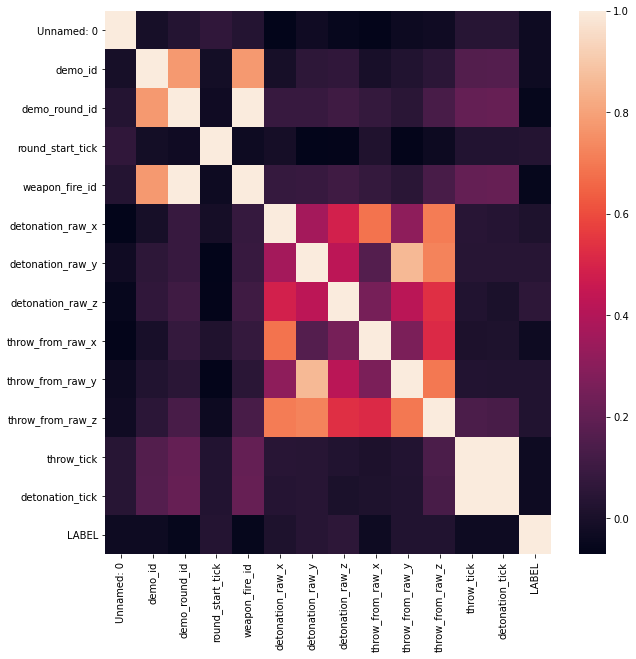

In [4]:
plt.figure(figsize = (10,10))
num_cols = train.select_dtypes(exclude=['object']).columns
corr = train[num_cols].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Feature Engineering 

In [7]:
from copy import deepcopy
train_copy = deepcopy(train)

In [3]:
train_copy['nade_duration(s)'] = (train_copy['detonation_tick'] - train_copy['throw_tick'])/128

In [4]:
train_copy = train_copy.drop(['demo_id','demo_round_id','Unnamed: 0','round_start_tick','weapon_fire_id'], axis = 1)

In [5]:
X = train.loc[:, train.columns != 'LABEL']
y = train['LABEL']

### Feature importance

In [59]:
e = pd.get_dummies(X[['team','TYPE','map_name']])


In [60]:
X = X.join(e)


In [61]:
X = X.drop(['team','TYPE','map_name'], axis = 1)


In [62]:
rf = RandomForestClassifier(n_estimators=200)

In [63]:
rf.fit(X,y)

RandomForestClassifier(n_estimators=200)

In [64]:
for name, score in zip(list(X.columns), rf.feature_importances_):
    print(name,score)

detonation_raw_x 0.11497953826201894
detonation_raw_y 0.11007923500783436
detonation_raw_z 0.10873599072705174
throw_from_raw_x 0.10503850128292971
throw_from_raw_y 0.10566589959393084
throw_from_raw_z 0.09269349466784763
throw_tick 0.09943481051250222
detonation_tick 0.10445375542533401
nade_duration(s) 0.09536492232808672
team_CT 0.011853662071328952
team_T 0.010760065120815747
TYPE_flashbang 0.009195415402192417
TYPE_molotov 0.013238227164249147
TYPE_smoke 0.012200402669688824
map_name_de_inferno 0.003365119977265522
map_name_de_mirage 0.002940959786923195


## PCA

In [65]:

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [66]:
1 - pca.explained_variance_ratio_.sum()

0.06281940156390697

In [67]:
X2D = pd.DataFrame(X2D, columns=['V1','V2'])
X2D = X2D.join(y)

In [68]:
X2D

V1           V2  LABEL
0   -1039.996874  2727.708120  False
1    4586.589132  -596.507823   True
2   -5066.822575  2262.353901   True
3    6287.516607 -2700.475202   True
4   -5366.460115   276.455503  False
..           ...          ...    ...
538   584.413272 -2739.026082   True
539   545.231552  2996.150839   True
540 -5402.518798 -3383.733944   True
541  3611.945217  3057.275857  False
542 -5697.418598 -1741.208517   True

[543 rows x 3 columns]

<AxesSubplot:xlabel='V1', ylabel='V2'>

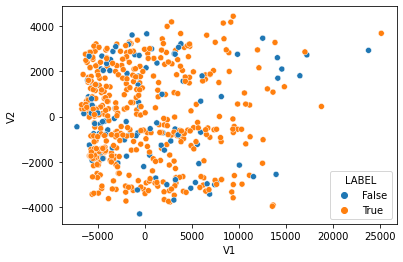

In [69]:
sns.scatterplot(x = X2D['V1'], y = X2D['V2'], hue = X2D['LABEL'])

# Prepare dataset to machine learning models 

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from sklearn.utils import resample



In [ ]:
minority = train[train['LABEL']==False]


df_minority_upsampled = resample(minority, 
                                 replace=True,     
                                 n_samples=200)

In [70]:
train_upsampled = pd.concat([train,df_minority_upsampled])

In [73]:
print(len(train_upsampled[train_upsampled['LABEL'] == True]))
len(train_upsampled[train_upsampled['LABEL'] == False])


430


313

Function to drop columns

In [9]:

class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        Nade_duration = (X['detonation_tick'] - X['throw_tick'])/128
        return np.c_[X,Nade_duration]

In [10]:
class DropAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_nums):
        self.attribute_nums = attribute_nums
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.delete(X,self.attribute_nums,1)

In [11]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [12]:
num_cols = ['Unnamed: 0',
 'demo_id',
 'demo_round_id',
 'round_start_tick',
 'weapon_fire_id',
 'detonation_raw_x',
 'detonation_raw_y',
 'detonation_raw_z',
 'throw_from_raw_x',
 'throw_from_raw_y',
 'throw_from_raw_z',
 'throw_tick',
 'detonation_tick']

cat_cols = ['team','TYPE','map_name']

In [13]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(num_cols)),
        ("Add_attributes", AttributesAdder()),
        ("Drop_attributes", DropAttributes([0,1,2,3,4])),
        ("scale", StandardScaler())
    ])

In [25]:
cat_pipeline = Pipeline([
    ("select cat", DataFrameSelector(cat_cols)),
    ("One hot encoder", OneHotEncoder(sparse=False))
])

In [28]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [74]:
X = preprocess_pipeline.fit_transform(train_upsampled)

In [77]:
y = train_upsampled['LABEL']

## Methods to deal with imbalanced dataset

In [58]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_validate

def score(model,X,y,cv):
    scoring = {'accuracy' : make_scorer(accuracy_score), 
            'precision' : make_scorer(precision_score),
            'recall' : make_scorer(recall_score), 
            'f1_score' : make_scorer(f1_score)}

    kfold = KFold(n_splits=cv, random_state=42) 

    results = cross_validate(estimator=model,
                                        X=X,
                                        y=y,
                                        cv=kfold,
                                        scoring=scoring)
    return results

# ML models

In [67]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [79]:
sgd = SGDClassifier()
sgd.fit(X,y)
score(sgd,X,y,5)

{'fit_time': array([0.00363612, 0.00368214, 0.0034945 , 0.00334144, 0.00286961]),
 'score_time': array([0.00330734, 0.00302219, 0.00285292, 0.00306392, 0.0029192 ]),
 'test_accuracy': array([0.48322148, 0.65100671, 0.67785235, 0.52027027, 0.00675676]),
 'test_precision': array([0.80645161, 0.83505155, 0.84466019, 0.54444444, 0.        ]),
 'test_recall': array([0.43478261, 0.69230769, 0.73109244, 0.62025316, 0.        ]),
 'test_f1_score': array([0.56497175, 0.75700935, 0.78378378, 0.57988166, 0.        ])}

In [78]:
lr = LogisticRegression()
lr.fit(X,y)
score(lr,X,y,5)

{'fit_time': array([0.02507544, 0.0154047 , 0.00958586, 0.01811552, 0.02016568]),
 'score_time': array([0.00402141, 0.00379443, 0.0035243 , 0.00444508, 0.00436211]),
 'test_accuracy': array([0.58389262, 0.69798658, 0.63087248, 0.62837838, 0.0472973 ]),
 'test_precision': array([0.77894737, 0.83333333, 0.82      , 0.60169492, 0.        ]),
 'test_recall': array([0.64347826, 0.76923077, 0.68907563, 0.89873418, 0.        ]),
 'test_f1_score': array([0.7047619 , 0.8       , 0.74885845, 0.72081218, 0.        ])}

In [80]:
svm = SVC(kernel='poly', degree=2, coef0=0.5)
svm.fit(X,y)
score(svm,X,y,5)

{'fit_time': array([0.01137376, 0.01083517, 0.01101017, 0.01186633, 0.01254797]),
 'score_time': array([0.00592184, 0.00451112, 0.00440383, 0.00434422, 0.00424361]),
 'test_accuracy': array([0.63758389, 0.63758389, 0.60402685, 0.64864865, 0.07432432]),
 'test_precision': array([0.82105263, 0.83157895, 0.84883721, 0.61157025, 0.        ]),
 'test_recall': array([0.67826087, 0.67521368, 0.61344538, 0.93670886, 0.        ]),
 'test_f1_score': array([0.74285714, 0.74528302, 0.71219512, 0.74      , 0.        ])}

In [81]:
dt = DecisionTreeClassifier(splitter='random')
dt.fit(X,y)
score(dt,X,y,5)

{'fit_time': array([0.00158572, 0.00182962, 0.00182319, 0.00223398, 0.00179935]),
 'score_time': array([0.00336075, 0.00272679, 0.00355101, 0.00414824, 0.00336623]),
 'test_accuracy': array([0.73825503, 0.76510067, 0.82550336, 0.83108108, 1.        ]),
 'test_precision': array([0.96341463, 0.93617021, 0.98947368, 0.86486486, 0.        ]),
 'test_recall': array([0.68695652, 0.75213675, 0.78991597, 0.81012658, 0.        ]),
 'test_f1_score': array([0.80203046, 0.83412322, 0.87850467, 0.83660131, 0.        ])}

In [82]:
rf = RandomForestClassifier(n_estimators=500,)
rf.fit(X,y)
score(rf,X,y,5)

{'fit_time': array([0.92831731, 0.99266744, 0.96582699, 0.98669171, 1.03775525]),
 'score_time': array([0.05041385, 0.05084038, 0.05047989, 0.05270267, 0.05082941]),
 'test_accuracy': array([0.83892617, 0.83892617, 0.89261745, 0.91216216, 1.        ]),
 'test_precision': array([0.95049505, 0.94285714, 0.99047619, 0.90243902, 0.        ]),
 'test_recall': array([0.83478261, 0.84615385, 0.87394958, 0.93670886, 0.        ]),
 'test_f1_score': array([0.88888889, 0.89189189, 0.92857143, 0.91925466, 0.        ])}

In [83]:
Xboost = xgb.XGBClassifier(n_estimators = 200)
Xboost.fit(X,y)
score(Xboost,X,y,5)

[12:14:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'fit_time': array([0.20667982, 0.18111062, 0.17911124, 0.19890761, 0.14210725]),
 'score_time': array([0.00359344, 0.00360703, 0.00416231, 0.00363278, 0.00358939]),
 'test_accuracy': array([0.83892617, 0.8590604 , 0.81208054, 0.89864865, 1.        ]),
 'test_precision': array([0.96907216, 0.94444444, 0.97894737, 0.88095238, 0.        ]),
 'test_recall': array([0.8173913 , 0.87179487, 0.78151261, 0.93670886, 0.        ]),
 'test_f1_score': array([0.88679245, 0.90666667, 0.86915888, 0.90797546, 0.        ])}